In [1]:
%reload_ext autoreload
%autoreload 2

from IPython.display import display
from pathlib import Path
from PIL import Image
import os

# set current path to $HOME/Projects/ocean-relic/
current_path = Path(os.path.expandvars('$HOME/Projects/ocean-relic/'))
assets_path = current_path / 'src/assets'

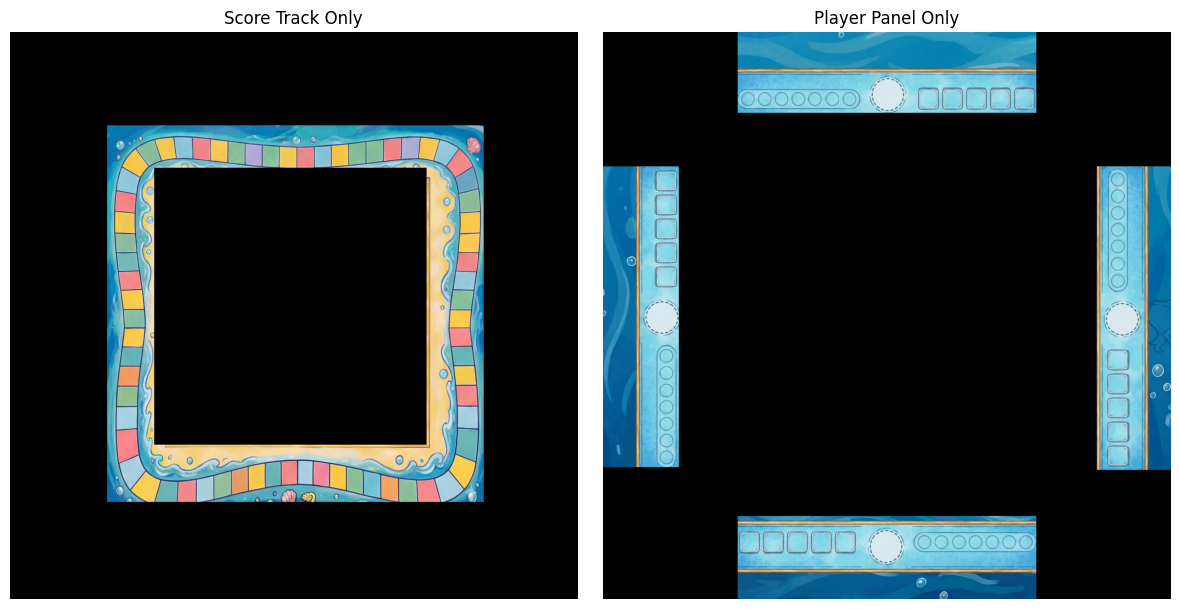

In [4]:
from collections import namedtuple
from typing import List, Tuple
from matplotlib import pyplot as plt
import cv2
import numpy as np
from dataclasses import dataclass


Point = namedtuple('Point', ['x', 'y'])

@dataclass
class BoundingBox:
    left_top: Point
    right_top: Point
    left_bottom: Point
    right_bottom: Point

    @property
    def width(self) -> int:
        return self.right_bottom.x - self.left_top.x

    @property
    def height(self) -> int:
        return self.right_bottom.y - self.left_top.y


def display_image(img: Image.Image | Path, target_width: int | None = None):
    if isinstance(img, Path):
        img = Image.open(img)

    if target_width is not None:
        # Calculate target height to preserve aspect ratio
        width_percent = target_width / float(img.width)
        target_height = int((float(img.height) * float(width_percent)))
        img = img.resize((target_width, target_height), Image.LANCZOS)

    display(img)


def visualize_regions(
    base: Image.Image,
    regions: List[BoundingBox], 
    color: Tuple[int, int, int] = (0, 255, 0),
    thickness: int = 8
):
    """
    Draw bounding boxes on image, optionally save, and display the 
    original and result side by side using matplotlib.
    Converts the PIL image to cv2 format internally for drawing.
    """
    # Convert PIL Image to cv2 image (numpy array, BGR)
    base_np = np.array(base)
    # PIL Image in RGB, so convert to BGR for OpenCV
    base_cv = cv2.cvtColor(base_np, cv2.COLOR_RGB2BGR)

    # Make a copy to draw on
    result_cv = base_cv.copy()
    for region in regions:
        pt1 = (region.left_top.x, region.left_top.y)
        pt2 = (region.right_bottom.x, region.right_bottom.y)
        cv2.rectangle(result_cv, pt1, pt2, color, thickness)

    # For displaying in matplotlib, convert back to RGB
    orig_rgb = cv2.cvtColor(base_cv, cv2.COLOR_BGR2RGB)
    result_rgb = cv2.cvtColor(result_cv, cv2.COLOR_BGR2RGB)

    # Plot side by side
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(orig_rgb)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title('With Detected Regions')
    plt.imshow(result_rgb)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


def overlay_on_board(
    base: Image.Image,
    overlay: Image.Image,
    areas: List[BoundingBox],
) -> Image.Image:
    """
    Overlay the overlay image on the base image at the specified area.
    Also return the coordinates of the rectangle area where the overlay image was placed (BoundingBox).
    """
    # Create a copy so as not to mutate original base
    composite = base.copy()

    for area in areas:
        # Resize overlay to fit specified area dimensions (width, height)
        target_size = (area.width, area.height)
        overlay_resized = overlay.resize(target_size, Image.LANCZOS)

        # Ensure overlay has alpha if needed for transparency
        if overlay_resized.mode != "RGBA":
            overlay_resized = overlay_resized.convert("RGBA")

        # Paste overlay onto composite at top-left corner of BoundingBox
        offset = area.left_top
        composite.paste(overlay_resized, offset, overlay_resized)

    # Return composite and the bounding box (as placed)
    return composite


black_img = Image.new("RGB", (2000, 2000), color=(0, 0, 0))

composite_board = Image.open(assets_path / 'composite-board.png')
score_track_only = overlay_on_board(
  composite_board,
  black_img,
  [
    # mid scene
    BoundingBox(
      left_top=Point(x=1040, y=986),
      right_top=Point(x=3004, y=986),
      left_bottom=Point(x=1040, y=2983),
      right_bottom=Point(x=3004, y=2983),
    ),
    # top
    BoundingBox(
      left_top=Point(x=0, y=0),
      right_top=Point(x=composite_board.width, y=0),
      left_bottom=Point(x=0, y=680),
      right_bottom=Point(x=composite_board.width, y=680),
    ),
    # left
    BoundingBox(
      left_top=Point(x=0, y=0),
      right_top=Point(x=700, y=0),
      left_bottom=Point(x=0, y=composite_board.height),
      right_bottom=Point(x=700, y=composite_board.height),
    ),
    # right
    BoundingBox(
      left_top=Point(x=composite_board.width - 680, y=0),
      right_top=Point(x=composite_board.width, y=0),
      left_bottom=Point(x=composite_board.width - 680, y=composite_board.height),
      right_bottom=Point(x=composite_board.width, y=composite_board.height),
    ),
    # bottom
    BoundingBox(
      left_top=Point(x=0, y=composite_board.height - 700),
      right_top=Point(x=composite_board.width, y=composite_board.height - 700),
      left_bottom=Point(x=0, y=composite_board.height),
      right_bottom=Point(x=composite_board.width, y=composite_board.height),
    ),
  ],
)


player_panel_only = overlay_on_board(
  composite_board,
  black_img,
  [
    # mid scene
    BoundingBox(
      left_top=Point(x=547, y=590),
      right_top=Point(x=3560, y=590),
      left_bottom=Point(x=547, y=3497),
      right_bottom=Point(x=3560, y=3497),
    ),
    # left top
    BoundingBox(
      left_top=Point(x=0, y=0),
      right_top=Point(x=971, y=0),
      left_bottom=Point(x=0, y=976),
      right_bottom=Point(x=971, y=976),
    ),
    # right top
    BoundingBox(
      left_top=Point(x=composite_board.width - 971, y=0),
      right_top=Point(x=composite_board.width, y=0),
      left_bottom=Point(x=composite_board.width - 971, y=976),
      right_bottom=Point(x=composite_board.width, y=976),
    ),
    # left bottom
    BoundingBox(
      left_top=Point(x=0, y=composite_board.height - 951),
      right_top=Point(x=971, y=composite_board.height - 951),
      left_bottom=Point(x=0, y=composite_board.height),
      right_bottom=Point(x=971, y=composite_board.height),
    ),
    # right bottom
    BoundingBox(
      left_top=Point(x=composite_board.width - 971, y=composite_board.height - 931),
      right_top=Point(x=composite_board.width, y=composite_board.height - 931),
      left_bottom=Point(x=0, y=composite_board.height),
      right_bottom=Point(x=composite_board.width, y=composite_board.height),
    ),
  ],
)

# display_image(composite_board, target_width=500)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(score_track_only)
axes[0].set_title('Score Track Only')
axes[0].axis('off')
axes[1].imshow(player_panel_only)
axes[1].set_title('Player Panel Only')
axes[1].axis('off')
plt.tight_layout()
plt.show()



Detected 70 score track regions
Detected 20 hands tiles regions
Detected 28 oxygen regions
Detected 4 user token regions


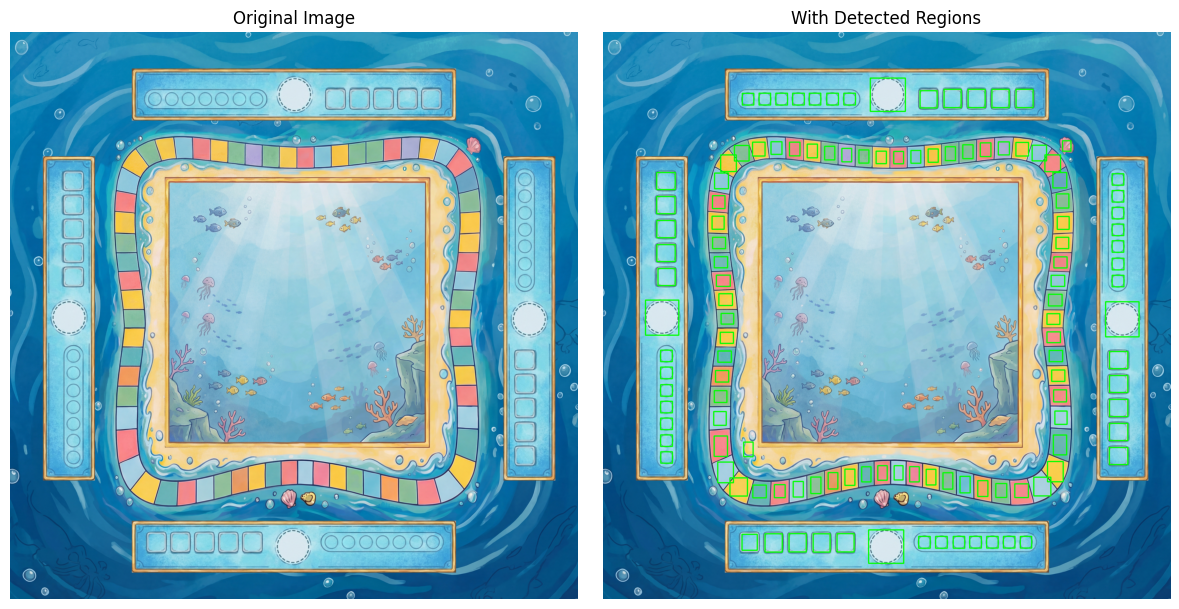

In [94]:
import cv2
import numpy as np
from collections import namedtuple
from typing import List, Tuple
from matplotlib import pyplot as plt

# Named tuples for clean data representation
RGB = namedtuple('RGB', ['r', 'g', 'b'])

class ColorRegionDetector:
    def __init__(self, image: Image.Image):
        """Initialize with an image file path."""
        self.image = np.array(image)
        # OpenCV loads as BGR, convert to RGB for easier reasoning
        self.image = cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB)
        self.height, self.width = self.image.shape[:2]

    def detect_closed_areas(
        self,
        min_width: int,
        max_width: int,
        min_height: int,
        max_height: int,
        shrink_factor: float | None = None
    ) -> List[BoundingBox]:
        # Read image
        gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        
        # Edge detection using Canny
        edges = cv2.Canny(gray, 100, 300)
        
        # Optional: dilate slightly to connect broken edges
        kernel = np.ones((2, 2), np.uint8)
        edges = cv2.dilate(edges, kernel, iterations=1)
        
        # Find contours
        contours, hierarchy = cv2.findContours(edges, 
                                                cv2.RETR_TREE,  # Get all contours with hierarchy
                                                cv2.CHAIN_APPROX_SIMPLE)
        
        # Filter contours by size
        bounding_boxes = []
        
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            # Check size constraints
            if (min_width <= w <= max_width and 
                min_height <= h <= max_height):
                
                # Optional: filter by aspect ratio (for squares)
                aspect_ratio = w / float(h)
                if 0.5 <= aspect_ratio <= 1.5:
                    bbox = BoundingBox(
                        left_top=Point(x=x, y=y),
                        left_bottom=Point(x=x, y=y + h),
                        right_top=Point(x=x + w, y=y),
                        right_bottom=Point(x=x + w, y=y + h),
                    )
                    bounding_boxes.append(bbox)

        # Merge overlapped regions
        bounding_boxes = self._merge_overlapped_regions(bounding_boxes)

        if shrink_factor is not None:
            bounding_boxes = self._shrink_regions(bounding_boxes, shrink_factor)
        
        return bounding_boxes

    def detect_color_areas(
        self,
        target_color: RGB,
        tolerance: int,
        min_width: int,
        max_width: int,
        min_height: int,
        max_height: int,
        shrink_factor: float | None = None
    ) -> List[BoundingBox]:
        color = np.array([target_color.b, target_color.g, target_color.r])
        upper_bound = np.array(list(map(lambda c: min(c + tolerance, 255), color)))
        lower_bound = np.array(list(map(lambda c: max(c - tolerance, 0), color)))
        mask = cv2.inRange(self.image, lower_bound, upper_bound)
        contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        bounding_boxes = []
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            if min_width <= w <= max_width and min_height <= h <= max_height:
                bbox = BoundingBox(
                    left_top=Point(x=x, y=y),
                    left_bottom=Point(x=x, y=y + h),
                    right_top=Point(x=x + w, y=y),
                    right_bottom=Point(x=x + w, y=y + h),
                )
                bounding_boxes.append(bbox)

        bounding_boxes = self._merge_overlapped_regions(bounding_boxes)

        if shrink_factor is not None:
            bounding_boxes = self._shrink_regions(bounding_boxes, shrink_factor)

        return bounding_boxes

    def _merge_overlapped_regions(
        self,
        regions: List[BoundingBox]
    ) -> List[BoundingBox]:
        """Merge overlapping bounding boxes."""
        if not regions:
            return []
        
        # Keep merging until no more overlaps found
        merged = True
        while merged:
            merged = False
            new_regions = []
            used = set()
            
            for i, box1 in enumerate(regions):
                if i in used:
                    continue
                
                # Check if box1 overlaps with any remaining boxes
                merged_box = box1
                for j in range(i + 1, len(regions)):
                    if j in used:
                        continue
                    
                    box2 = regions[j]
                    
                    # Check for overlap
                    if self._boxes_overlap(box1, box2):
                        # Merge the two boxes
                        merged_box = self._merge_two_boxes(merged_box, box2)
                        used.add(j)
                        merged = True
                
                new_regions.append(merged_box)
                used.add(i)
            
            regions = new_regions
        
        return regions

    def _boxes_overlap(self, box1: BoundingBox, box2: BoundingBox, overlap_threshold: float = 0.5) -> bool:
        """Check if two bounding boxes overlap based on overlap area threshold."""
        # Get min/max coordinates for each box
        x1_min = min(box1.left_top.x, box1.left_bottom.x)
        x1_max = max(box1.right_top.x, box1.right_bottom.x)
        y1_min = min(box1.left_top.y, box1.right_top.y)
        y1_max = max(box1.left_bottom.y, box1.right_bottom.y)
        
        x2_min = min(box2.left_top.x, box2.left_bottom.x)
        x2_max = max(box2.right_top.x, box2.right_bottom.x)
        y2_min = min(box2.left_top.y, box2.right_top.y)
        y2_max = max(box2.left_bottom.y, box2.right_bottom.y)
        
        # Calculate merged box dimensions (max extent)
        merged_width = max(x1_max, x2_max) - min(x1_min, x2_min)
        merged_height = max(y1_max, y2_max) - min(y1_min, y2_min)
        merged_area = merged_width * merged_height
        
        # Calculate individual box areas
        area1 = (x1_max - x1_min) * (y1_max - y1_min)
        area2 = (x2_max - x2_min) * (y2_max - y2_min)
        
        # Calculate overlap area using the formula: overlap = area1 + area2 - merged_area
        overlap_area = area1 + area2 - merged_area
        
        # If no overlap, return False
        if overlap_area <= 0:
            return False
        
        # Use the smaller box area as reference
        min_area = min(area1, area2)
        
        # Check if overlap area exceeds threshold
        return overlap_area / min_area >= overlap_threshold

    def _merge_two_boxes(self, box1: BoundingBox, box2: BoundingBox) -> BoundingBox:
        """Merge two bounding boxes into one that encompasses both."""
        # Get min/max coordinates
        x_min = min(box1.left_top.x, box1.left_bottom.x, 
                    box2.left_top.x, box2.left_bottom.x)
        x_max = max(box1.right_top.x, box1.right_bottom.x,
                    box2.right_top.x, box2.right_bottom.x)
        y_min = min(box1.left_top.y, box1.right_top.y,
                    box2.left_top.y, box2.right_top.y)
        y_max = max(box1.left_bottom.y, box1.right_bottom.y,
                    box2.left_bottom.y, box2.right_bottom.y)
        
        return BoundingBox(
            left_top=Point(x=x_min, y=y_min),
            right_top=Point(x=x_max, y=y_min),
            left_bottom=Point(x=x_min, y=y_max),
            right_bottom=Point(x=x_max, y=y_max),
        )

    def _shrink_regions(
        self, 
        regions: List[BoundingBox], 
        shrink_factor: float
    ) -> List[BoundingBox]:
        """Shrink regions by shrinking width/height around the center point."""
        shrunk_regions = []
        for region in regions:
            # Calculate center
            cx = (region.left_top.x + region.right_top.x + region.left_bottom.x + region.right_bottom.x) / 4
            cy = (region.left_top.y + region.right_top.y + region.left_bottom.y + region.right_bottom.y) / 4

            # New width and height
            new_w = region.width * shrink_factor
            new_h = region.height * shrink_factor

            # Recalculate coordinates around center
            left = int(round(cx - new_w / 2))
            right = int(round(cx + new_w / 2))
            top = int(round(cy - new_h / 2))
            bottom = int(round(cy + new_h / 2))

            shrunk = BoundingBox(
                left_top=Point(left, top),
                right_top=Point(right, top),
                left_bottom=Point(left, bottom),
                right_bottom=Point(right, bottom),
            )
            shrunk_regions.append(shrunk)
        return shrunk_regions


score_track_detector = ColorRegionDetector(score_track_only)
score_track_regions = score_track_detector.detect_closed_areas(
    min_width=100,
    min_height=110,
    max_width=400,
    max_height=400,
    shrink_factor=0.6
)
print(f"Detected {len(score_track_regions)} score track regions")

player_panel_detector = ColorRegionDetector(player_panel_only)
hands_tiles_region = player_panel_detector.detect_closed_areas(
    min_width=130,
    min_height=130,
    max_width=180,
    max_height=180,
    shrink_factor=0.8
)
print(f"Detected {len(hands_tiles_region)} hands tiles regions")

oxygen_regions = player_panel_detector.detect_color_areas(
    target_color=RGB(r=136, g=215, b=229),
    tolerance=16,
    min_width=80,
    min_height=80,
    max_width=90,
    max_height=90
)
print(f"Detected {len(oxygen_regions)} oxygen regions")

user_token_regions = player_panel_detector.detect_color_areas(
    target_color=RGB(r=217, g=233, b=238),
    tolerance=20,
    min_width=230,
    min_height=230,
    max_width=260,
    max_height=260
)
print(f"Detected {len(user_token_regions)} user token regions")

visualize_regions(composite_board, score_track_regions + hands_tiles_region + oxygen_regions + user_token_regions)

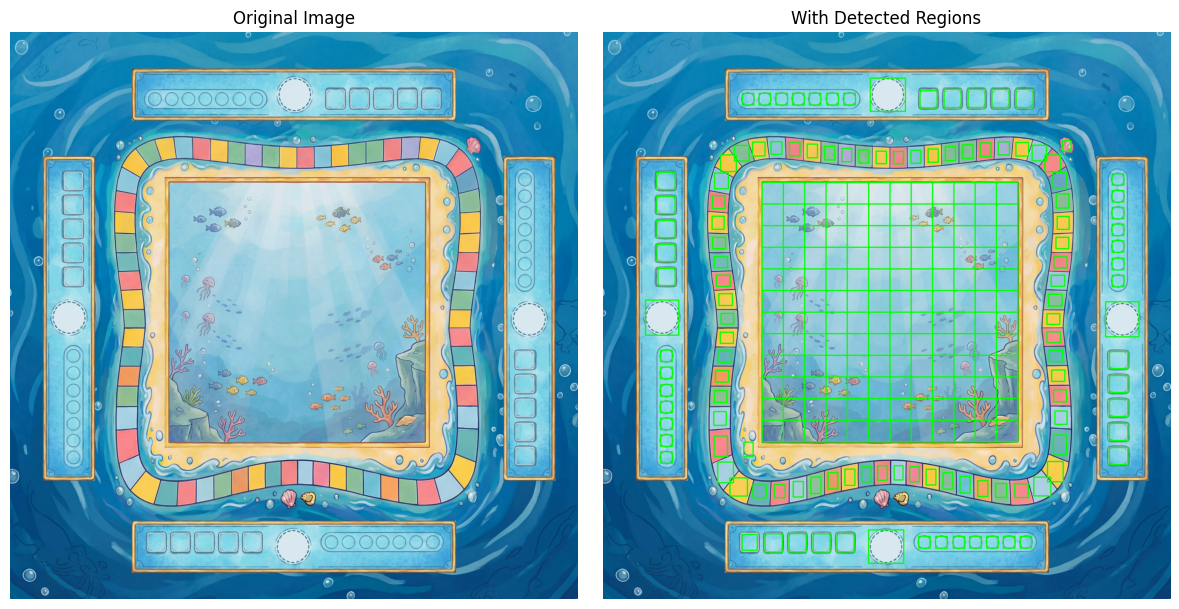

In [96]:
def on_scene_grid_regions(
  scene_bbox: BoundingBox,
  segments: int = 10,
) -> List[BoundingBox]:
  """
  Divide the input scene_bbox into an evenly spaced grid of BoundingBoxes.
  Returns a flat list of grid cell BoundingBoxes (row-major order).
  """
  cells = []
  min_x, min_y = scene_bbox.left_top.x, scene_bbox.left_top.y
  max_x, max_y = scene_bbox.right_bottom.x, scene_bbox.right_bottom.y
  cell_w = (max_x - min_x) / segments
  cell_h = (max_y - min_y) / segments

  for row in range(segments):
    for col in range(segments):
      x0 = int(min_x + col * cell_w)
      y0 = int(min_y + row * cell_h)
      x1 = int(min_x + (col + 1) * cell_w)
      y1 = int(min_y + (row + 1) * cell_h)
      cell_bbox = BoundingBox(
        left_top=Point(x=x0, y=y0),
        left_bottom=Point(x=x0, y=y1),
        right_top=Point(x=x1, y=y0),
        right_bottom=Point(x=x1, y=y1),
      )
      cells.append(cell_bbox)
  return cells


grid_regions = on_scene_grid_regions(
  BoundingBox(
    left_top=Point(x=1147, y=1092),
    left_bottom=Point(x=1147, y=2962),
    right_top=Point(x=2991, y=1092),
    right_bottom=Point(x=2991, y=2962),
  ), 
12)
all_mask_regions = score_track_regions + hands_tiles_region + grid_regions + oxygen_regions + user_token_regions

visualize_regions(composite_board, all_mask_regions)  

In [97]:
import json
from pathlib import Path

def bbox_to_dict(bbox):
  return {
    "lt": {"x": bbox.left_top.x, "y": bbox.left_top.y},
    "lb": {"x": bbox.left_bottom.x, "y": bbox.left_bottom.y},
    "rt": {"x": bbox.right_top.x, "y": bbox.right_top.y},
    "rb": {"x": bbox.right_bottom.x, "y": bbox.right_bottom.y},
    "w": bbox.width,
    "h": bbox.height,
  }

score_track_json = [bbox_to_dict(b) for b in score_track_regions]
hands_tiles_json = [bbox_to_dict(b) for b in hands_tiles_region]
grid_regions_json = [bbox_to_dict(b) for b in grid_regions]
oxygen_json = [bbox_to_dict(b) for b in oxygen_regions]
user_token_json = [bbox_to_dict(b) for b in user_token_regions]

grid_info_data = {
  "score_track_regions": score_track_json,
  "hands_tiles_region": hands_tiles_json,
  "scene_grid_regions": grid_regions_json,
  "oxygen_regions": oxygen_json,
  "user_token_regions": user_token_json,
}

grid_info_path = (current_path / "src/assets/grid_info.json")
with open(grid_info_path, "w") as f:
  json.dump(grid_info_data, f, indent=2)

